In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [3]:
# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
df.shape

(1494, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2017-12-18 to 2023-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1494 non-null   float64
 1   High       1494 non-null   float64
 2   Low        1494 non-null   float64
 3   Close      1494 non-null   float64
 4   Adj Close  1494 non-null   float64
 5   Volume     1494 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 81.7 KB


In [6]:
# Check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])


In [8]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [9]:
train, test = split_data(df['Close_ms'], 0.8) #90% Train

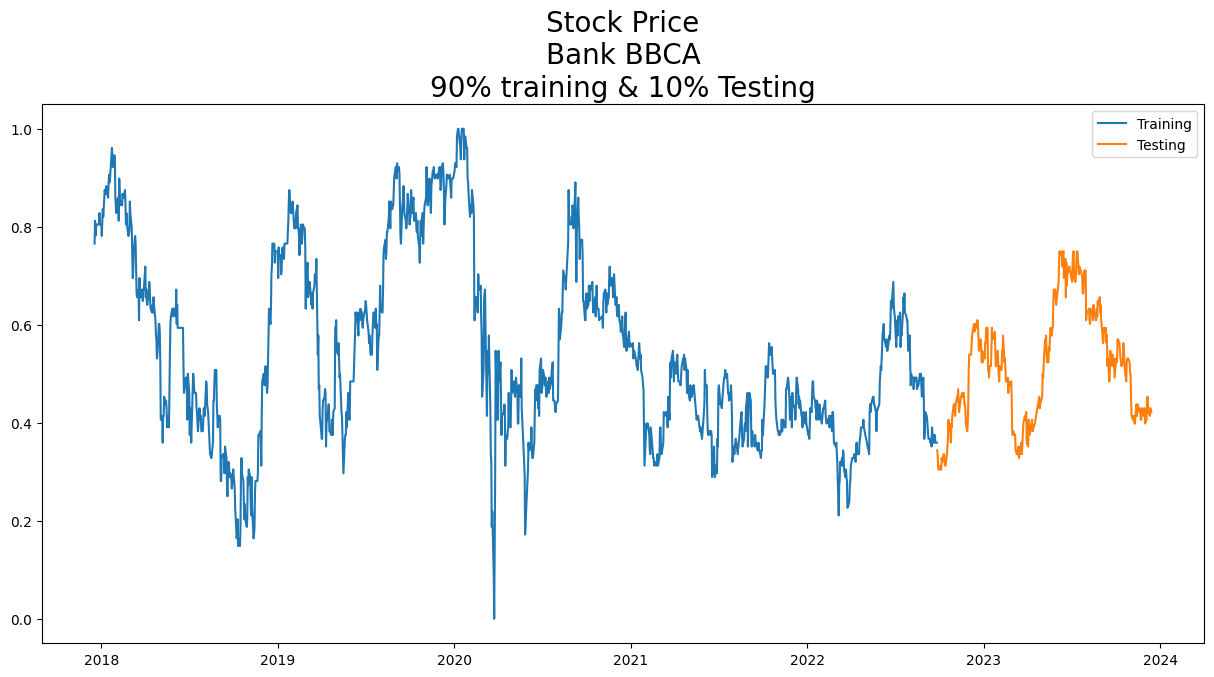

In [10]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Stock Price\nBank BBCA\n90% training & 10% Testing', fontsize=20)
plt.show()

In [11]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [12]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [13]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [14]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [15]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [16]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 11808

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

In [18]:
history = model.fit(X_train,
                    y_train,
                    epochs=150,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/150


10/10 [==============================] - 5s 84ms/step - loss: 0.1686 - mae: 0.5481 - val_loss: 0.1369 - val_mae: 0.5106
Epoch 2/150
10/10 [==============================] - 0s 9ms/step - loss: 0.1657 - mae: 0.5431 - val_loss: 0.1347 - val_mae: 0.5064
Epoch 3/150
10/10 [==============================] - 0s 9ms/step - loss: 0.1631 - mae: 0.5384 - val_loss: 0.1322 - val_mae: 0.5015
Epoch 4/150
10/10 [==============================] - 0s 8ms/step - loss: 0.1603 - mae: 0.5333 - val_loss: 0.1295 - val_mae: 0.4961
Epoch 5/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1573 - mae: 0.5278 - val_loss: 0.1267 - val_mae: 0.4904
Epoch 6/150
10/10 [==============================] - 0s 16ms/step - loss: 0.1540 - mae: 0.5217 - val_loss: 0.1237 - val_mae: 0.4844
Epoch 7/150
10/10 [==============================] - 0s 9ms/step - loss: 0.1508 - mae: 0.5157 - val_loss: 0.1206 - val_mae: 0.4781
Epoch 8/150
10/10 [==============================] - 0s 9ms/step - loss: 0.1474

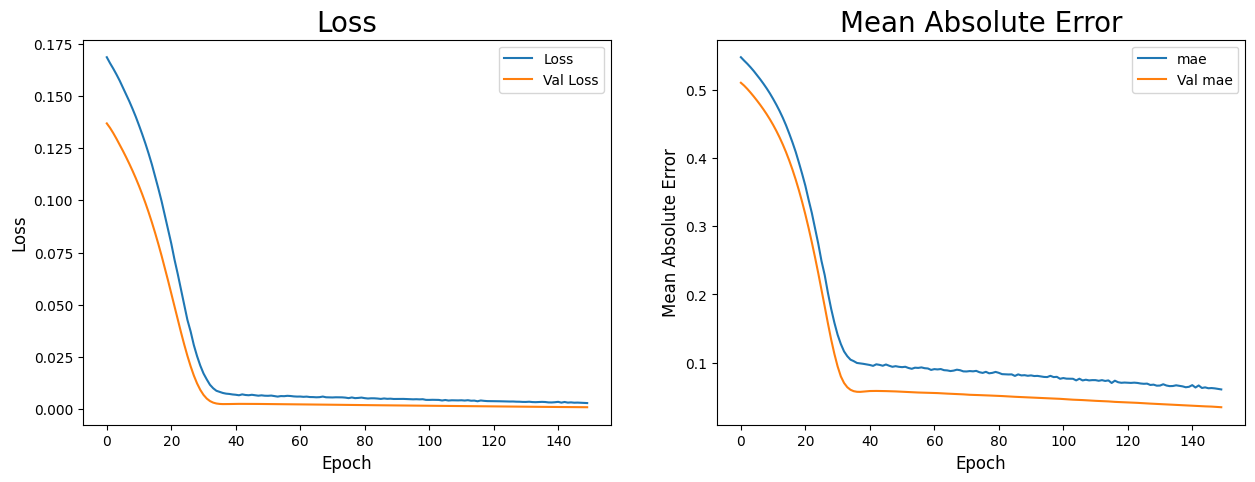

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

10/10 [==============================] - 1s 3ms/step


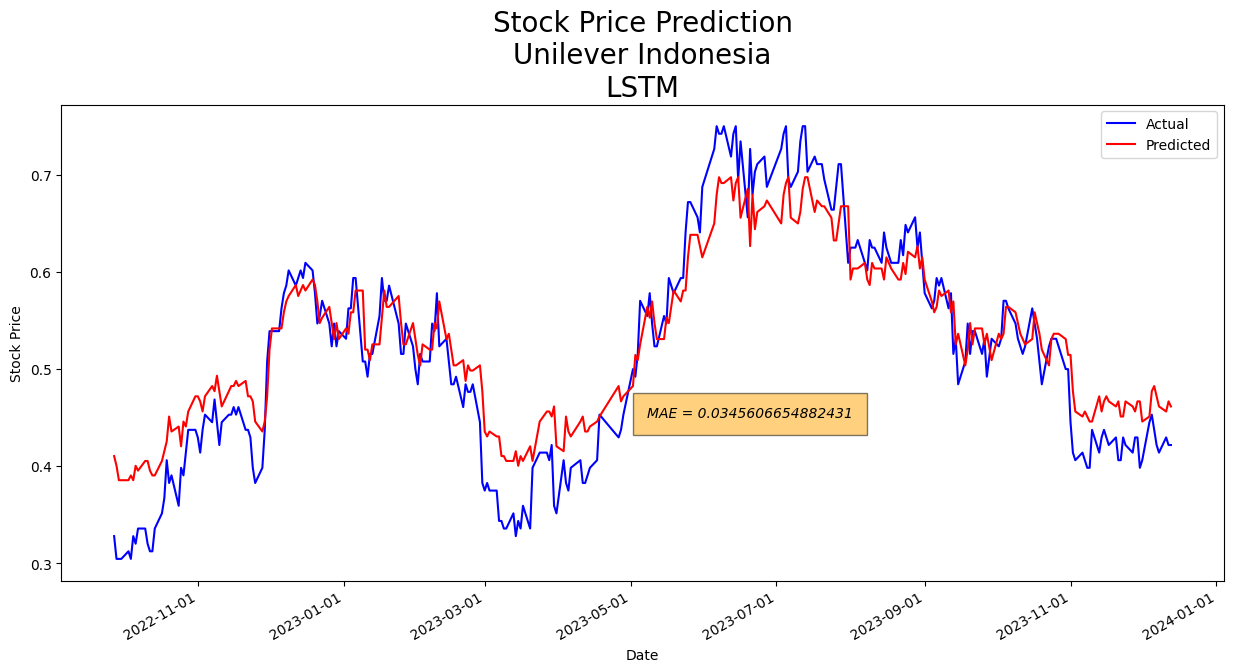

In [20]:
# Perform prediction on the test data
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Actual')  # Exclude the last element to match the length
plt.plot(test.index[:-1], y_pred, color='red', label='Predicted')  # Exclude the last element to match the length
plt.text(test.index[149], 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [21]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

MAE:  0.0345606654882431
RSME:  0.04190038704175466
MAPE:  0.07575032414157201


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1493,) + inhomogeneous part.

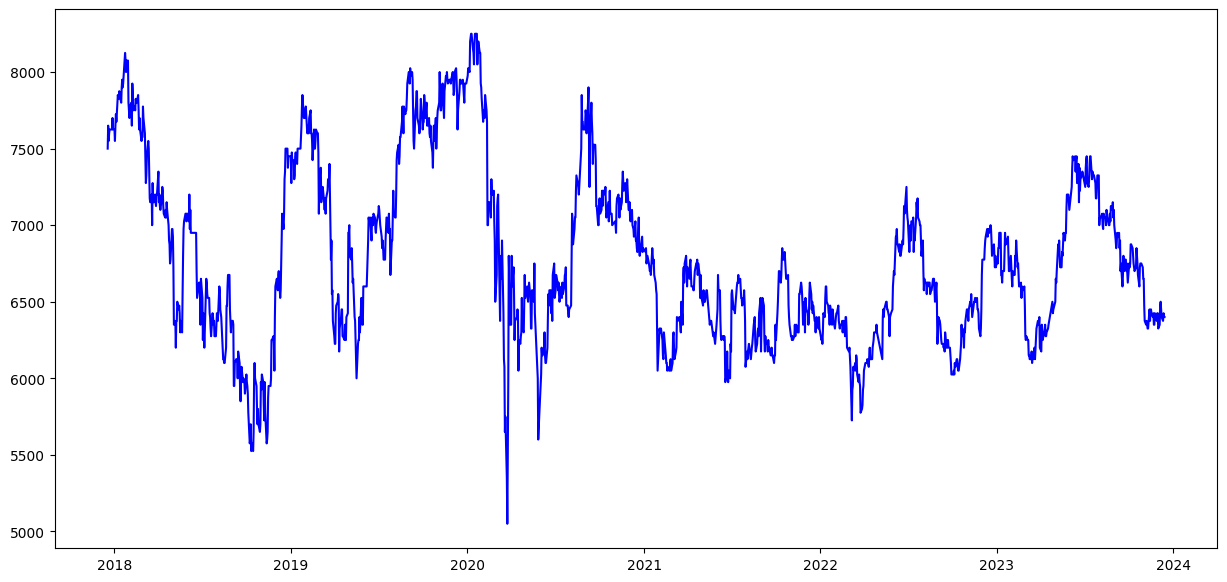

In [25]:
# Inverse transform the predicted values
y_pred_original = ms.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index[:-1], [None] * len(train.index) + list(y_pred_original), color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1494,) and (1791,)

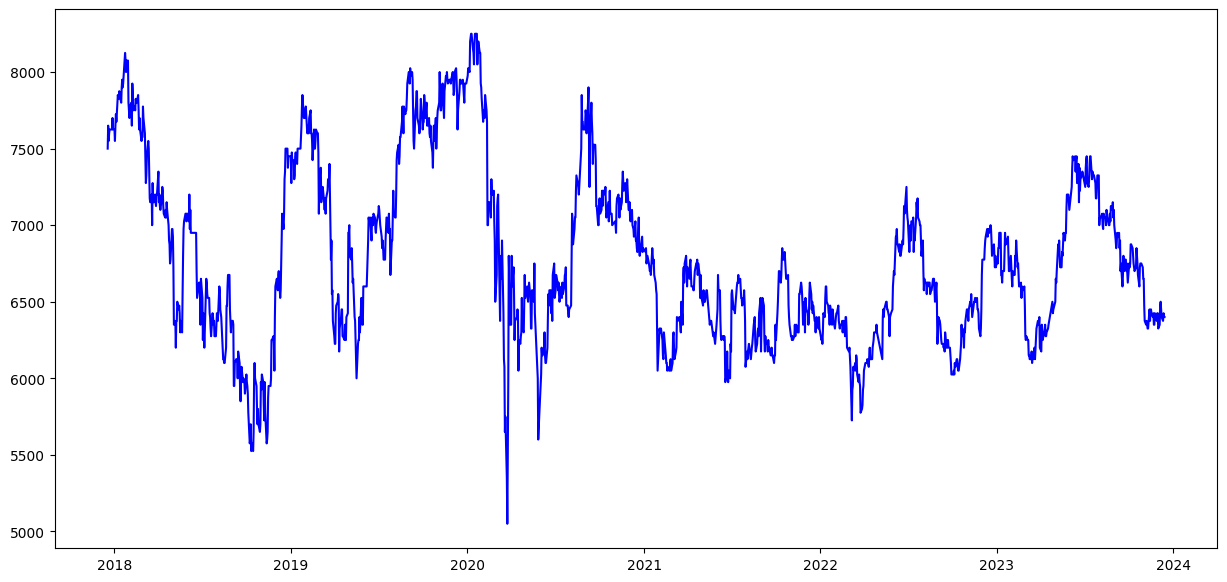

In [26]:
# Buat list kosong untuk menyimpan nilai-nilai yang akan digambarkan
predicted_values = [None] * len(df.index[:-1])  # Buat elemen-elemen "None" sebanyak yang dibutuhkan

# Tambahkan nilai-nilai yang diprediksi ke list predicted_values
predicted_values += list(y_pred_original.flatten())  # Gunakan flatten() untuk mengubah array 2D menjadi 1D

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index, predicted_values, color='red', label='Predicted')  # Gunakan predicted_values yang sudah dibuat
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nIndofood Sukses Makmur Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1493,) and (1791,)

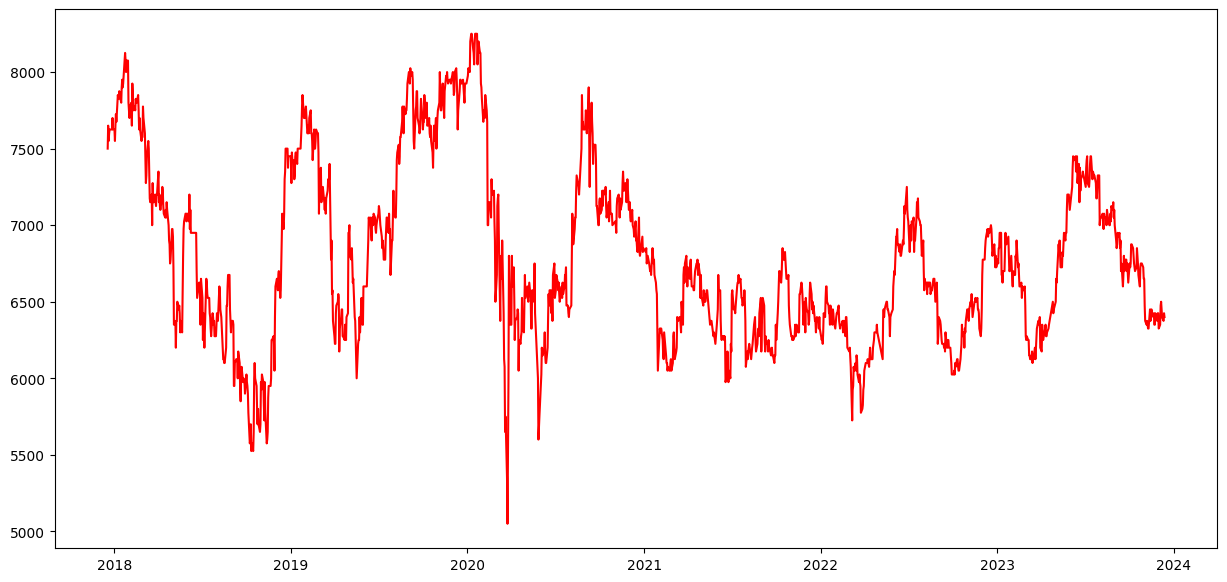

In [27]:
# Buat list indeks baru yang sesuai dengan panjang predicted_values
index_predicted = df.index[:-1]  # Menggunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='red', label='Actual')  # Menggunakan index_predicted
plt.plot(index_predicted, predicted_values, color='red', label='Predicted')  # Menggunakan predicted_values
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nIndofood Sukses Makmur Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


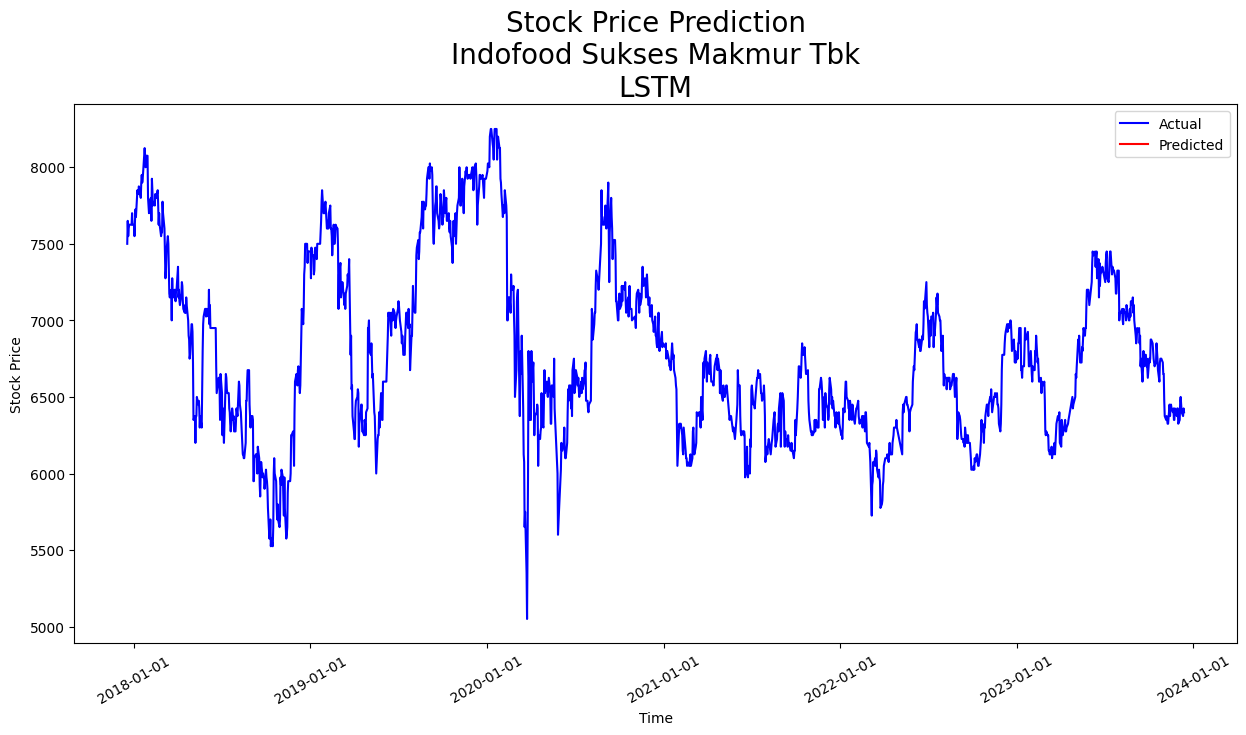

In [28]:
# Menyesuaikan panjang data sumbu x dan y
index_predicted = df.index[:-1]  # Gunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='blue', label='Actual')  # Gunakan index_predicted
plt.plot(index_predicted, predicted_values[:len(index_predicted)], color='red', label='Predicted')  # Gunakan predicted_values yang disesuaikan panjangnya
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nIndofood Sukses Makmur Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


In [29]:
# Simpan nilai dari X_test terakhir untuk digunakan dalam prediksi
last_sequence = X_test[-1]

# Buat list untuk menyimpan prediksi
future_predictions = []

# Lakukan prediksi untuk 30 hari ke depan
for i in range(30):
    # Lakukan prediksi untuk satu langkah waktu ke depan
    next_pred = model.predict(last_sequence.reshape(1, 1, 1))[0][0]
    
    # Tambahkan prediksi ke list future_predictions
    future_predictions.append(next_pred)
    
    # Update last_sequence dengan nilai prediksi yang baru untuk digunakan pada iterasi berikutnya
    last_sequence = np.append(last_sequence[1:], next_pred)

# Ubah future_predictions menjadi numpy array
future_predictions = np.array(future_predictions)

# Tampilkan future_predictions
print("Prediksi untuk 30 hari ke depan:")
print(future_predictions)


1/1 [==============================] - 0s 27ms/step
Prediksi untuk 30 hari ke depan:
[0.46157125 0.48827866 0.50653136 0.51913726 0.5279057  0.5340349
 0.53833395 0.54135644 0.543485   0.54498583 0.54604495 0.5467926
 0.5473208  0.54769397 0.5479577  0.54814416 0.5482759  0.54836905
 0.54843485 0.54848146 0.5485144  0.5485376  0.5485541  0.54856575
 0.548574   0.5485798  0.548584   0.5485869  0.54858893 0.54859036]


In [30]:
# Denormalisasi future_predictions menggunakan objek MinMaxScaler (ms)
future_predictions_denormalized = ms.inverse_transform(future_predictions.reshape(-1, 1))

# Tampilkan future_predictions_denormalized
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(future_predictions_denormalized)


Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
[[6527.028 ]
 [6612.4917]
 [6670.9   ]
 [6711.2397]
 [6739.2983]
 [6758.912 ]
 [6772.6685]
 [6782.341 ]
 [6789.152 ]
 [6793.9546]
 [6797.3433]
 [6799.736 ]
 [6801.427 ]
 [6802.6206]
 [6803.4644]
 [6804.061 ]
 [6804.483 ]
 [6804.781 ]
 [6804.991 ]
 [6805.1406]
 [6805.246 ]
 [6805.321 ]
 [6805.3735]
 [6805.4106]
 [6805.4365]
 [6805.455 ]
 [6805.4688]
 [6805.478 ]
 [6805.485 ]
 [6805.4893]]


In [31]:
# Buat DataFrame untuk menyimpan prediksi
predictions_df = pd.DataFrame(future_predictions_denormalized, columns=["Predicted Price"])

# Tambahkan kolom tanggal untuk 30 hari ke depan
last_date = df.index[-1]  # Ambil tanggal terakhir dari data asli
date_range = pd.date_range(start=last_date, periods=30, freq='D')  # Buat rentang tanggal untuk 30 hari ke depan
predictions_df['Date'] = date_range

# Atur kolom tanggal sebagai indeks
predictions_df.set_index('Date', inplace=True)

# Tampilkan DataFrame prediksi
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(predictions_df)



Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
            Predicted Price
Date                       
2023-12-14      6527.027832
2023-12-15      6612.491699
2023-12-16      6670.899902
2023-12-17      6711.239746
2023-12-18      6739.298340
2023-12-19      6758.912109
2023-12-20      6772.668457
2023-12-21      6782.340820
2023-12-22      6789.151855
2023-12-23      6793.954590
2023-12-24      6797.343262
2023-12-25      6799.735840
2023-12-26      6801.426758
2023-12-27      6802.620605
2023-12-28      6803.464355
2023-12-29      6804.061035
2023-12-30      6804.482910
2023-12-31      6804.780762
2024-01-01      6804.991211
2024-01-02      6805.140625
2024-01-03      6805.246094
2024-01-04      6805.320801
2024-01-05      6805.373535
2024-01-06      6805.410645
2024-01-07      6805.436523
2024-01-08      6805.455078
2024-01-09      6805.468750
2024-01-10      6805.478027
2024-01-11      6805.484863
2024-01-12      6805.489258
